In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\Hi\AppData\Local\Temp\ipykernel_20220\555797462.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
#FOLDER_PATH = "/Users/admin/codes/jupyter_codes/data/"
FOLDER_PATH = "data/"

In [3]:
file_path = FOLDER_PATH+"lending_club_2020_train.csv"
origin_data = pd.read_csv(file_path)
origin_data.head()

C:\Users\Hi\AppData\Local\Temp\ipykernel_20220\2516111998.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  origin_data = pd.read_csv(file_path)


,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,...,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag
0,124989905,6000.0,6000.0,6000.0,36 months,7.97%,187.94,A,A5,Teacher,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
1,139665484,35000.0,35000.0,35000.0,60 months,14.47%,822.95,C,C2,Product Specialist,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
2,84253847,23200.0,23200.0,23200.0,60 months,24.99%,680.82,E,E4,Production Foreman,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y
3,126296074,4500.0,4500.0,4500.0,36 months,9.93%,145.06,B,B2,Office Manager,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
4,148913312,15000.0,15000.0,15000.0,36 months,16.40%,530.33,C,C4,Secretary,...,May-2020,Jul-2020,May-2020,2.0,0.0,ACTIVE,413.83,11025.25,54.62,N


In [4]:
# drop할 컬럼들을 일단 처리한다.
with open('data/'+'drop_columns.txt', mode='r') as f:
    drop_fields = f.readlines()
    drop_fields = [drop_field.strip('\n') for drop_field in drop_fields]

In [5]:
drop_df = origin_data.drop(columns=drop_fields)

In [6]:
len(drop_df.columns)

96

In [7]:
drop_df['loan_status'].value_counts()

loan_status
Fully Paid                                             898522
Current                                                618688
Charged Off                                            217366
Late (31-120 days)                                       9840
In Grace Period                                          6049
Late (16-30 days)                                        1620
Issued                                                   1258
Does not meet the credit policy. Status:Fully Paid       1223
Does not meet the credit policy. Status:Charged Off       460
Default                                                   268
Name: count, dtype: int64

In [8]:
modified_df = drop_df[~drop_df['loan_status'].isin(['Current', 'Issued', 'Does not meet the credit policy. Status:Fully Paid', 'Does not meet the credit policy. Status:Charged Off'])]

In [9]:
modified_df.loc[modified_df['loan_status'].isin(['Fully Paid', 'In Grace Period']), 'loan_status'] = 0
modified_df.loc[modified_df['loan_status'].isin(['Charged Off', 'Default', 'Late (16-30 days)', 'Late (31-120 days)']), 'loan_status'] = 1

In [10]:
len(modified_df)

1133666

In [11]:
len(modified_df.duplicated())

1133666

In [12]:
modified_df = modified_df.dropna(subset=modified_df.columns.difference(['loan_status']),how='all')

In [13]:
# term : 36 months -> 36 으로 변환해줘야한다.
# modified_df['term'] = modified_df['term'].astype(str).apply(delete_suffix)

# 이 함수는 쓸 일 없어짐(int_rate 필드 drop함)
# modified_df['int_rate'] = modified_df['int_rate'].astype(str).apply(delete_suffix_percentage)

# modified_df['revol_util'] = modified_df['revol_util'].astype(str).apply(delete_suffix_percentage)

# zip_code : 554xx -> 554로 변환해줘야한다.
# modified_df['zip_code'] = modified_df['zip_code'].astype(str).apply(delete_suffix_xx)


# columns_to_modify = ['earliest_cr_line','last_pymnt_d','next_pymnt_d',
#                      'last_credit_pull_d','sec_app_earliest_cr_line',
#                      'hardship_start_date','hardship_end_date',
#                      'payment_plan_start_date', 'issue_d']
# apply_to_multiple_columns(columns_to_modify)

def delete_suffix(term:str)->int:
    '''첫 단어만을 저장하는 함수'''
    term = term.strip().split()[0]
    return int(term)

def delete_suffix_percentage(term:str)->float:
    '''%를 자르는 함수'''
    term = term.strip('%')
    return float(term)

def delete_suffix_xx(term:str)->int:
    '''xx를 자르는 함수'''
    term = term.strip('xx')
    return int(term)

def apply_to_multiple_columns(date_columns:list)->None:
    '''modified_df에서 %b-%Y(Aug-2006) 형식의 날짜 정보를 %Y-%m-%d(2006-08-01)형태로 저장하는 함수'''
    for col in date_columns:
        modified_df[col]=pd.to_datetime(modified_df[col], format='%b-%Y')

def process_emp_length(term:str)->int:
    if term =='< 1 year':
        return 0
    elif term=='10+ years':
        return 10
    term = term.strip()

In [14]:
modified_df['term'] = modified_df['term'].astype(str).apply(delete_suffix)

In [15]:
modified_df.select_dtypes('object').columns

Index(['sub_grade', 'emp_title', 'emp_length', 'home_ownership',
       'verification_status', 'loan_status', 'purpose', 'zip_code',
       'addr_state', 'revol_util', 'application_type',
       'sec_app_earliest_cr_line'],
      dtype='object')

In [16]:
THRESHOLD = 50

null_percentages = (modified_df.isnull().sum() * 100) / len(modified_df)
columns_to_drop = null_percentages[null_percentages >= THRESHOLD].index
columns_to_keep = null_percentages[null_percentages < THRESHOLD].index
# 필드 추출
filtered_df = modified_df[columns_to_keep]
filtered_df.columns
columns_to_drop

Index(['mths_since_last_delinq', 'mths_since_last_record',
       'mths_since_last_major_derog', 'annual_inc_joint', 'dti_joint',
       'mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq',
       'revol_bal_joint', 'sec_app_fico_range_low', 'sec_app_fico_range_high',
       'sec_app_earliest_cr_line', 'sec_app_inq_last_6mths',
       'sec_app_mort_acc', 'sec_app_open_acc', 'sec_app_revol_util',
       'sec_app_open_act_il', 'sec_app_num_rev_accts',
       'sec_app_chargeoff_within_12_mths',
       'sec_app_collections_12_mths_ex_med'],
      dtype='object')

In [32]:
filtered_df['out_prncp'].value_counts()

out_prncp
0.00        1115938
20000.00         16
10000.00         10
15000.00          8
40000.00          7
             ...   
2163.31           1
22363.56          1
421.09            1
9755.02           1
10497.96          1
Name: count, Length: 17271, dtype: int64

In [46]:
result_df = filtered_df[(filtered_df['pub_rec_bankruptcies'] != 0)]
print(filtered_df['pub_rec_bankruptcies'].isna().sum())
filtered_df['pub_rec_bankruptcies'].value_counts()

439


pub_rec_bankruptcies
0.0     992516
1.0     133256
2.0       5796
3.0       1186
4.0        305
5.0        109
6.0         34
7.0         14
8.0          6
9.0          2
11.0         1
12.0         1
Name: count, dtype: int64

In [18]:
filtered_df.shape

(1133665, 77)

In [23]:
filtered_df.select_dtypes('object').columns

Index(['sub_grade', 'emp_title', 'emp_length', 'home_ownership',
       'verification_status', 'loan_status', 'purpose', 'zip_code',
       'addr_state', 'revol_util', 'application_type'],
      dtype='object')

<Axes: xlabel='revol_bal'>

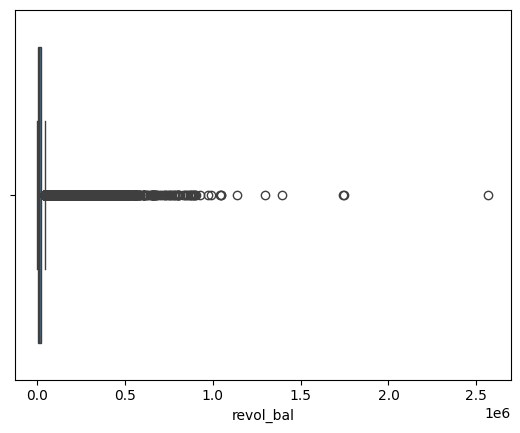

In [20]:
sns.boxplot(data=filtered_df, x='revol_bal')

In [20]:
sns.boxplot(data=filtered_df, x='revol_bal', y='loan_status')

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x000002AAD99F16C0> (for post_execute):


KeyboardInterrupt: 

In [ ]:
filtered_df.shape

(1133665, 77)

In [ ]:
def check_field(column_name:str)->None:
    print("==============isnull")
    print(filtered_df[column_name].isnull().sum()*100/len(filtered_df[column_name]), '%')
    print("==============isna")
    print(filtered_df[column_name].isna().sum()*100/len(filtered_df[column_name]), '%')
    print("==============head")
    print(filtered_df[column_name].head())
    print("==============value_count")
    print(filtered_df[column_name].value_counts())

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 47. 48. 49. 54. 55. 56. 60. 68.
 71. 79.]
0.0
77.51806449076132
1.0
78.11345545949652
2.0
78.34533465994367
3.0
78.9634628565403
4.0
79.12815290615698
5.0
79.06845288564807
6.0
79.37089632004886
7.0
79.73486906443551
8.0
79.4604896642721
9.0
79.50622240064232
10.0
78.73389969854755
11.0
79.06284864261808
12.0
77.67232767232767
13.0
78.67507886435331
14.0
79.80049875311721
15.0
81.50105708245243
16.0
77.84256559766764
17.0
77.82101167315174
18.0
80.76923076923077
19.0
74.83443708609272
20.0
80.34934497816595
21.0
75.69060773480663
22.0
76.35135135135135
23.0
79.5275590551181
24.0
77.98165137614679
25.0
84.81012658227849
26.0
74.64788732394366
27.0
83.72093023255815
28.0
79.48717948717949
29.0
62.5
30.0
62.5
31.0
61.111111111111114
32.0
75.0
33.0
93.75
34.0
71.42857142857143
35.0
83.33333333333333
36.0
8

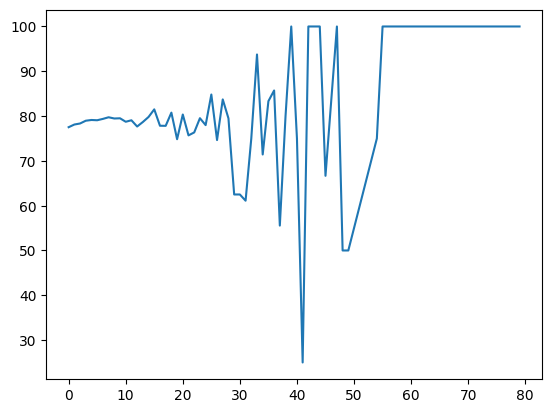

In [ ]:
target_column = "total_cu_tl"
column_values =filtered_df[target_column].unique()
column_values = column_values[~pd.isna(column_values)]
column_values.sort()
print(column_values)
x = []
y =[]
for value in column_values:
    pos_percent = len(filtered_df[(filtered_df[target_column]==value) & (filtered_df['loan_status']==0)])*100/len(filtered_df[filtered_df[target_column]==value])
    print(value)
    print(pos_percent)
    x.append(value)
    y.append(pos_percent)

print("na")
print(len(filtered_df[(filtered_df[target_column].isna()) & (filtered_df['loan_status']==0)])*100/len(filtered_df[filtered_df[target_column].isna()]))
plt.plot(x, y)

In [ ]:
filtered_df.shape

(1133665, 77)

In [ ]:
check_field("purpose")

==============isnull
0.0 %
==============isna
0.0 %
==============head
0    debt_consolidation
2    debt_consolidation
5      home_improvement
6      home_improvement
7           credit_card
Name: purpose, dtype: object
==============value_count
purpose
debt_consolidation    648300
credit_card           251730
home_improvement       75174
other                  69046
major_purchase         25495
medical                13778
small_business         12550
car                    12240
vacation                8140
moving                  7965
house                   6922
wedding                 1339
renewable_energy         806
educational              180
Name: count, dtype: int64


In [ ]:
'''
emp length, 
desc, 
earliest cr line, 
fico range low, 
fico range high
'''

'\nemp length, \ndesc, \nearliest cr line, \nfico range low, \nfico range high\n'

In [ ]:
pub_rec_bankruptcies_df = filtered_df[filtered_df['total_cu_tl'].isna()]
len(pub_rec_bankruptcies_df[pub_rec_bankruptcies_df['loan_status']==1])*100/len(pub_rec_bankruptcies_df)

18.04207278923075

36 83.73268998337672 16.267310016623284
60 68.17991937673622 31.820080623263777


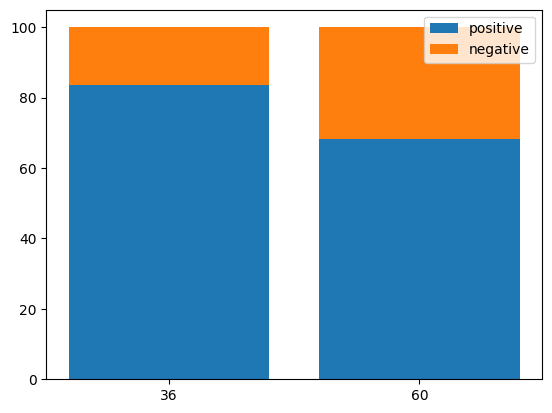

In [ ]:
def print_term():
    x = np.arange(2)
    months = [36, 60]
    pos = []
    neg = []
    filtered_df.head()
    for data in months:
        month_df = filtered_df[filtered_df['term']==data]
        positive_percent = len(month_df[month_df['loan_status']==0])*100/len(month_df)
        negative_percent = 100-positive_percent
        pos.append(positive_percent)
        neg.append(negative_percent)
        print(data, positive_percent, negative_percent)
    plt.bar(x, pos, label='positive')
    plt.xticks(x, months)
    plt.bar(x, neg, label='negative', bottom=pos)
    plt.legend()
    plt.show()
print_term()

In [ ]:
def print_sub_grade():
    x = []
    y = []
    for c in ['A', 'B', 'C','D','E','F','G']:
        for i in range(1, 6):
            sub_grade = c+str(i)
            sub_grade_df = filtered_df[filtered_df["sub_grade"]==sub_grade]
            positive_percent = len(sub_grade_df[sub_grade_df['loan_status']==0])*100/len(sub_grade_df)
            x.append(sub_grade)
            y.append(positive_percent)
            print(sub_grade, positive_percent)
    plt.plot(x,y)    
print_sub_grade()